# Characterize CTD Rosette-Mounted LISST Data

Load data from Raw Data Archive Cruise Data for Pioneer MAB cruises:
 * <a>https://rawdata.oceanobservatories.org/files/cruise_data/Pioneer-MAB/Pioneer-21_AR87_2025-03-28/LISST/</a>

Separate upcast from downcast data. Compare optical transmission. Also include dashed lines around LISST suspect span (per Sequoia manual). Compare profiles of optical transmission and total volume concentration between casts across distance and time.

## Import libraries

In [1]:
# Import libraries used in this notebook
import os
import re
import glob
import urllib.request as request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cmocean
import cmocean.cm as cmo
import scipy.signal as signal

## Define functions and path to data

Also load the headers for CSV parsing at this step.

In [2]:
# Load LISST CSV column names from json containing column headers
headers = pd.read_json("./inst_headers/lisst_hdr.json", typ='series', orient='records')
csvhdr = headers.iloc[0]

In [3]:
# Data loading function and constants
# Base url for data on Raw Data Archive
RDA_URL = "https://rawdata.oceanobservatories.org/files/cruise_data/Pioneer-MAB/Pioneer-21_AR87_2025-03-28/LISST/"

# General LISST data download and parsing into dataset
def load_lisst(lisst_path, header):
    # Load LISST data from CSV
    lisst_df = pd.read_csv(lisst_path, names=header)
    try: lisst_df.head(1)
    except: print("No LISST data downloaded")
    
    # Create LISST time vector for Dataframe Index
    lisst_time = pd.to_datetime(lisst_df[
        ["year", "month", "day", "hour", "minute", "second"]
        ], yearfirst=True, utc=True)
    lisst_df.insert(0, "time", lisst_time.values)
    lisst_df.set_index("time", drop=True, inplace=True)
    
    # Convert data frame to Xarray Dataset for easy manipulation
    lisst_ds = xr.Dataset.from_dataframe(lisst_df)
    
    # Create 2D array for binned volume concentration
    volumecon2D = list([])
    bins = list([])
    for var in lisst_ds.variables:
        if re.search("volumecon[0-9]+", var):
                bins.append(var)
                volumecon2D.append(lisst_ds[var])
    lisst_ds = lisst_ds.drop_vars(bins)
    str2num = lambda x: int(x.replace("volumecon", ""))
    bins = [str2num(x) for x in bins]
    lisst_ds["volume_concentration_2D"] = xr.concat(
        volumecon2D, pd.Index(bins, name="bin")
        )
    lisst_ds["volume_concentration_2D"] = lisst_ds["volume_concentration_2D"].assign_attrs(units="$\mu$L/L")

    # Mask data where depth < 0
    depth_mask = lisst_ds.time[lisst_ds.depth>=0].values
    lisst_ds = lisst_ds.sel(time=depth_mask)
    return lisst_ds

<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_36604\735805488.py:35: SyntaxWarning: invalid escape sequence '\m'
  lisst_ds["volume_concentration_2D"] = lisst_ds["volume_concentration_2D"].assign_attrs(units="$\mu$L/L")


In [4]:
# Scrape the LISST readme file on the RDA
# to get CSV file names for each cast
def scrape_lisst_list(readme_file):
    castfiles = {}
    filenext = False
    text, urlheaders =  request.urlretrieve(RDA_URL+readme_file)
    with open(text) as f:
        for x in f:
            if "CAST" in x:
                # print(x)
                cast = x.replace("    ", "")[:-1]
                filenext = True
                continue
            if (filenext is True)&(".CSV" in x):
                # print(x)
                file = x.replace("    ", "")[:-1]
                castfiles[cast] = file
                filenext = False
            else:
                continue
    # Sort dict values into list of tuples with
    # key, value pairs in castfiles:
    pairs = list(castfiles.items())
    return pairs

In [5]:
# Define plotting and colormap functions
def addprofile2axes(ax, data, variable, color, legendtitle=None, legendcol=1):
    ax.plot(data[variable], data["depth"],
             c=color, label=data.cast, alpha = 0.75)
    ax.legend(fontsize='xx-small', ncol=legendcol, title=legendtitle)
    ax.set_xlabel(variable.replace("_"," ").title())
    return ax

def rgb_from_dict(list_in, cmap):
    # Get dictionary for colormap with one color for each cast
    cmdict = cmocean.tools.get_dict(cmap, N=len(list_in))
    # Make lists of RGB values for cast loop
    red = [float(x[1]) for x in cmdict["red"]]
    green = [float(x[1]) for x in cmdict["green"]]
    blue = [float(x[1]) for x in cmdict["blue"]]
    rgb = list(zip(red, green, blue,))
    return rgb

In [ ]:
# # Define additional plotting function to split data
# # into upcast and downcast and then use twiny to plot
# # given axes and 3 data arrays.
# # This was from an old notebook and was copied
# # here in case it was useful later.
# def plot_prtsz_comparison(ax1, volume_concentration,
#                           beam_transmission, depth):
#     midpt = int(len(beam_transmission)/2)
#     ax2 = ax1.twiny()
#     ax1.plot(volume_concentration[:midpt], depth[:midpt], c="black")
#     ax1.plot(volume_concentration[midpt-1:], depth[midpt-1:], "--", c="black", lw=1)
#     ax1.invert_yaxis()
#     ax1.set_xlabel("Total volume concentration [PPM]")
#     ax1.set_ylabel("Depth [m]")
#     ax2.plot(beam_transmission[:midpt], depth[:midpt], c="skyblue")
#     ax2.plot(beam_transmission[midpt-1:], depth[midpt-1:], "--", c="skyblue", lw=1)
#     ax2.set_xlabel("Beam transmission %", color="skyblue")
#     return 

In [6]:
# Load list of key, value pairs for each cast
readme_file = "AR87_LISST_README.txt"
pairs = scrape_lisst_list(readme_file)

## Test workflow with data from a single LISST cast

This section will usually remain commented out to prevent running the code unnecessarily.

In [ ]:
# # Test example: Load one dataset using RDA URL
# lisst_path = RDA_URL + value
# lisst_ds = load_lisst(lisst_path, csvhdr)

# # Add dataset attribute with cast name string
# lisst_ds = lisst_ds.assign_attrs(cast=key)
# lisst_ds # Saved output below has a data view of the Xarray Dataset


<xarray.Dataset> Size: 182kB
Dimensions:                  (time: 366, bin: 36)
Coordinates:
  * time                     (time) datetime64[ns] 3kB 2025-03-28T21:59:42 .....
  * bin                      (bin) int64 288B 1 2 3 4 5 6 ... 31 32 33 34 35 36
Data variables: (12/26)
    laser_transmission       (time) float64 3kB 0.9978 0.9777 ... 0.9047 0.8972
    supply_voltage           (time) float64 3kB 10.64 10.66 ... 10.58 10.58
    ext_in1                  (time) int64 3kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    laser_ref                (time) float64 3kB 1.055 1.055 ... 0.9505 0.9495
    depth                    (time) float64 3kB 0.16 1.35 1.09 ... 0.01 0.24
    temperature              (time) float64 3kB 6.177 5.746 ... 5.183 5.184
    ...                       ...
    rawpressure2             (time) int64 3kB 22559 22746 22705 ... 22536 22572
    ambient_light            (time) int64 3kB 4 3 3 3 4 3 3 3 ... 5 4 6 5 6 7 7
    ext_in3                  (time) float64 3kB 1.722 1.264 1.77 ... 1.438 1.495
    optical_transmission     (time) float64 3kB 0.97 0.951 0.964 ... 0.976 0.969
    beam_attenuation         (time) float64 3kB 1.212 2.027 ... 0.972 1.266
    volume_concentration_2D  (bin, time) float64 105kB 0.0 0.0 ... 0.0009 0.0
Attributes:
    cast:     AR87a_CAST001_L6

In [ ]:
# # Test plotting workflow to add cast data to existing axes
# color = [red[0], green[0], blue[0]]
# fig, ax0 = plt.subplots()

# # Load one dataset using RDA URL
# lisst_path = RDA_URL + value
# lisst_ds = load_lisst(lisst_path, csvhdr)
# # Add dataset attribute with cast name string
# lisst_ds = lisst_ds.assign_attrs(cast=key)
# # Add plot of a parameter in ds to axes
# ax0 = addprofile2axes(ax0, lisst_ds, "optical_transmission", color)

# ax0.invert_yaxis()
# ax0.grid()
# plt.legend()

In [ ]:
# # Test plotting workflow to add cast data to existing axes
# color = "orange"
# fig, ax1 = plt.subplots()

# # Load one dataset using RDA URL
# lisst_path = RDA_URL + value
# lisst_ds = load_lisst(lisst_path, csvhdr)
# # Add dataset attribute with cast name string
# lisst_ds = lisst_ds.assign_attrs(cast=key)
# # Add plot of a parameter in ds to axes
# ax1 = addprofile2axes(ax1, lisst_ds, "total_volumecon", color)

# ax1.invert_yaxis()
# ax1.grid()
# plt.legend()

In [ ]:
# # Test plotting workflow to add cast data to existing axes
# fig, axs2 = plt.subplots(1, 2, sharey=True)
# color = "orange"

# # Load one dataset using RDA URL
# lisst_path = RDA_URL + value
# lisst_ds = load_lisst(lisst_path, csvhdr)
# # Add dataset attribute with cast name string
# lisst_ds = lisst_ds.assign_attrs(cast=key)
# # Add plot of parameters in ds to different axes
# axs2[0] = addprofile2axes(axs2[0], lisst_ds, "laser_ref", color)
# # plt.legend()
# # ax3 = plt.twiny(ax2)
# axs2[1] = addprofile2axes(axs2[1], lisst_ds, "temperature", color)

# axs2[0].invert_yaxis()
# axs2[0].grid()
# axs2[1].grid()
# # plt.legend()

In [ ]:
# # Test plotting workflow to add cast data to existing axes
# fig, axs3 = plt.subplots(1, 2, sharey=True)
# color = "orange"

# # Load one dataset using RDA URL
# lisst_path = RDA_URL + value
# lisst_ds = load_lisst(lisst_path, csvhdr)
# # Add dataset attribute with cast name string
# lisst_ds = lisst_ds.assign_attrs(cast=key)
# # Add plot of parameters in ds to different axes
# axs3[0] = addprofile2axes(axs3[0], lisst_ds, "laser_transmission", color)
# plt.legend()
# axs3[1] = addprofile2axes(axs3[1], lisst_ds, "temperature", color)

# axs3[0].invert_yaxis()
# axs3[0].grid()
# axs3[1].grid()
# plt.legend()

In [ ]:
# # Test plotting workflow to add cast data to existing axes
# color = "orange"
# fig, ax1 = plt.subplots()

# # Load one dataset using RDA URL
# lisst_path = RDA_URL + value
# lisst_ds = load_lisst(lisst_path, csvhdr)
# # Add dataset attribute with cast name string
# lisst_ds = lisst_ds.assign_attrs(cast=key)
# # Add plot of a parameter in ds to axes
# ax1 = addprofile2axes(ax1, lisst_ds, "ambient_light", color)

# ax1.invert_yaxis()
# ax1.grid()
# plt.legend()

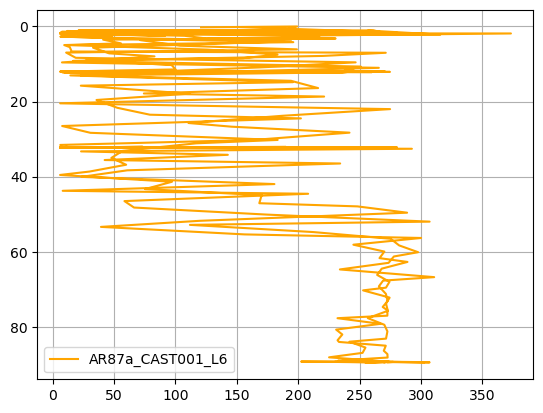

In [ ]:
# # Test plotting workflow to add cast data to existing axes
# color = "orange"
# fig, ax1 = plt.subplots()

# # Load one dataset using RDA URL
# lisst_path = RDA_URL + value
# lisst_ds = load_lisst(lisst_path, csvhdr)
# # Add dataset attribute with cast name string
# lisst_ds = lisst_ds.assign_attrs(cast=key)
# # Add plot of a parameter in ds to axes
# ax1 = addprofile2axes(ax1, lisst_ds, "mean_diameter", color)

# ax1.invert_yaxis()
# ax1.grid()
# plt.legend()

In [ ]:
# # Plot Welch PSD of mean particle diameter
# # TO-DO: add the frequency-space kernel w/ first lobe wide enough to cut off noise
# #   FWHM above the parts below 10^-4 level?
# f, Pdiameter_density = signal.welch(lisst_ds["mean_diameter"], fs=2)
# plt.semilogy(f, Pdiameter_density)

## Casts grouped by cruise leg

In [7]:
# Split the list into legs A and B
pairs87a = [x for x in pairs if "87a" in x[0]]
pairs87b = [x for x in pairs if "87b" in x[0]]

In [8]:
# Get RGB values for each set of casts
rgb_a = rgb_from_dict(pairs87a, cmo.ice_r)
rgb_b = rgb_from_dict(pairs87b, cmo.algae)

### Compare optical transmission data by depth

In [9]:
# define a function to plot casts in a group
def plot_lisst_profiles(lisst_casts, rgb, current_axes, param, legendtitle=None, legendcol=1):
    # loop through list of LISST cast files
    n = 0
    loop = lisst_casts.copy()
    while len(loop)>0:
        color = rgb[n]
        key, value = loop.pop(0)
        lisst_path = RDA_URL + value
        lisst_ds = load_lisst(lisst_path, csvhdr)
        lisst_ds = lisst_ds.assign_attrs(cast=key)
        # Add cast data to existing axes
        current_axes = addprofile2axes(current_axes, lisst_ds, param, color,
                                       legendtitle=legendtitle, legendcol=legendcol)
        # Advance counter for colors
        n += 1
    return current_axes

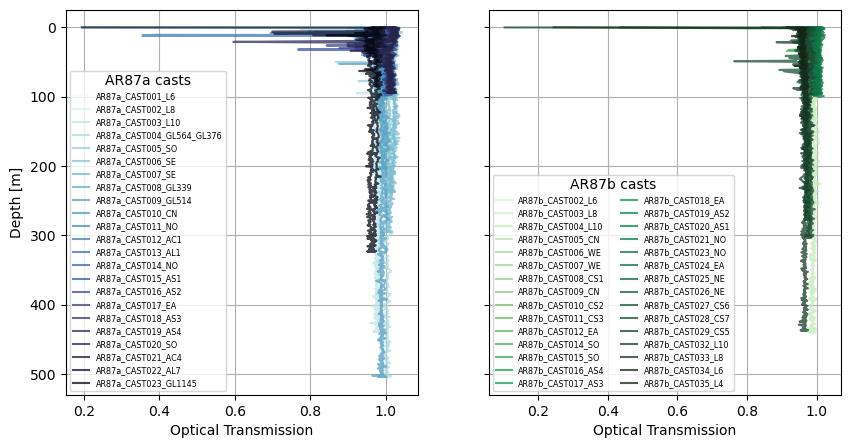

In [ ]:
# Plot optical transmission for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
ax0[0] = plot_lisst_profiles(pairs87a, rgb_a, ax0[0],
                             "optical_transmission", legendtitle="AR87a casts")

# loop through list of AR87b files
ax0[1] = plot_lisst_profiles(pairs87b, rgb_b, ax0[1],
                             "optical_transmission", legendtitle="AR87b casts",
                             legendcol=2)

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()

### Compare total volume concentration by depth

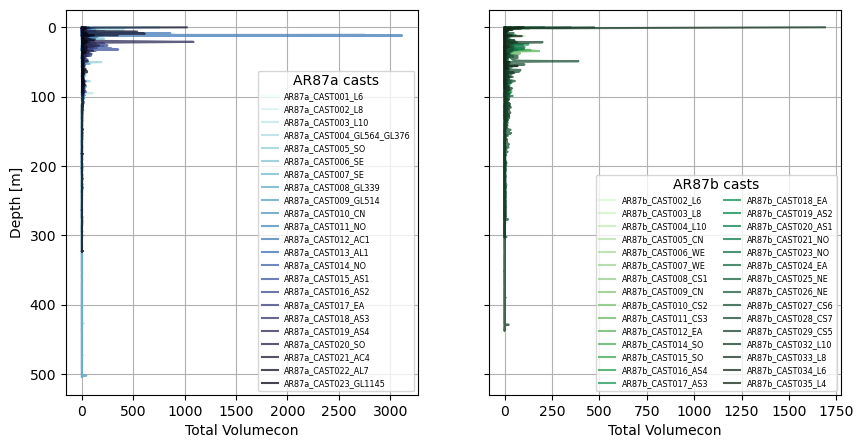

In [108]:
# Add cast data to one axes for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
n = 0
loop1 = pairs87a.copy()
while len(loop1)>0:
    color = rgb_a[n]
    key, value = loop1.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax0[0] = addprofile2axes(ax0[0], lisst_ds, "total_volumecon", color, legendtitle="AR87a casts")
    # Advance counter for colors
    n += 1

# loop through list of AR87b files
n = 0
loop2 = pairs87b.copy()
while len(loop2)>0:
    color = rgb_b[n]
    key, value = loop2.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax0[1] = addprofile2axes(ax0[1], lisst_ds, "total_volumecon", color, legendtitle="AR87b casts", legendcol=2)
    # Advance counter for colors
    n += 1

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()

### Compare reference laser power and temperature

<ul>
    <li>Profiles by depth</li>
    <ul>
        <li>twin x-axes</li>
        <li>subplots side-by-side</li>
    </ul>
    <li>Scatter plot</li>
    <ul>
        <li>with linear regression if there appears to be a relationship</li>
    </ul>
</ul>

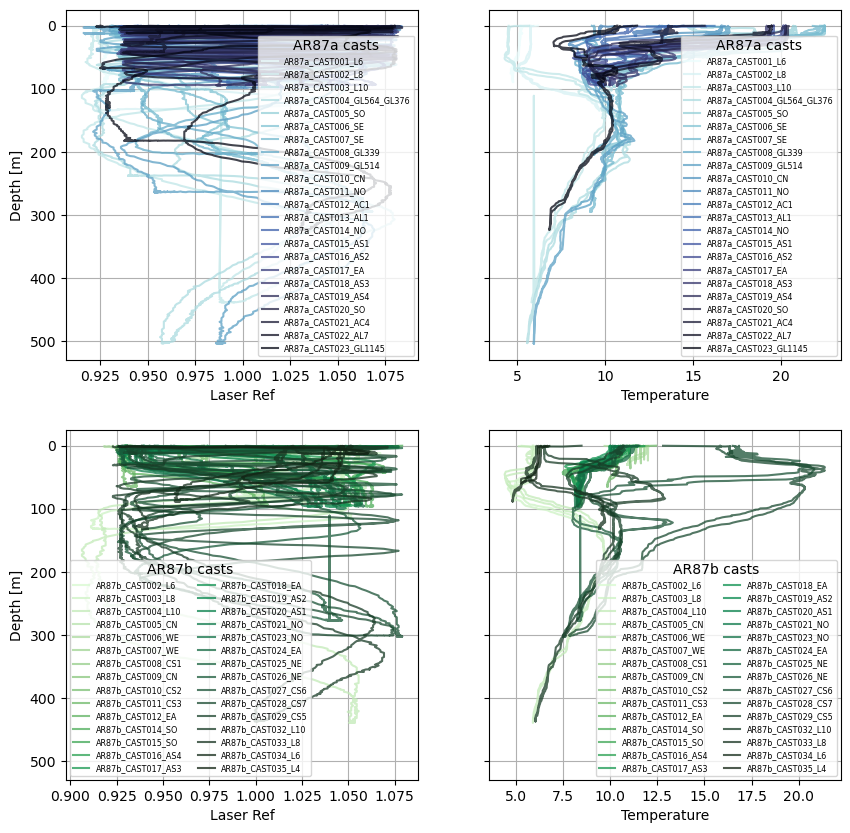

In [114]:
# Add cast data to one axes for each leg
fig, ax2 = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

# Top row is AR87a
# loop through list of AR87a files
n = 0
loop1 = pairs87a.copy()
while len(loop1)>0:
    color = rgb_a[n]
    key, value = loop1.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax2[0, 0] = addprofile2axes(ax2[0, 0], lisst_ds, "laser_ref", color, legendtitle="AR87a casts")
    ax2[0, 1] = addprofile2axes(ax2[0, 1], lisst_ds, "temperature", color, legendtitle="AR87a casts")
    # Advance counter for colors
    n += 1

# Bottom row is AR87b
# loop through list of AR87b files
n = 0
loop2 = pairs87b.copy()
while len(loop2)>0:
    color = rgb_b[n]
    key, value = loop2.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax2[1, 0] = addprofile2axes(ax2[1, 0], lisst_ds, "laser_ref", color, legendtitle="AR87b casts", legendcol=2)
    ax2[1, 1] = addprofile2axes(ax2[1, 1], lisst_ds, "temperature", color, legendtitle="AR87b casts", legendcol=2)
    # Advance counter for colors
    n += 1

# Add final figure elements
ax2[0, 0].invert_yaxis()
ax2[0, 0].grid()
ax2[0, 0].set_ylabel("Depth [m]")
ax2[0, 1].grid()

# ax2[1, 0].invert_yaxis()
ax2[1, 0].grid()
ax2[1, 0].set_ylabel("Depth [m]")
ax2[1, 1].grid()

### Compare laser transmission power and temperature

<ul>
    <li>Profiles by depth</li>
    <ul>
        <li>twin x-axes</li>
        <li>subplots side-by-side</li>
    </ul>
    <li>Scatter plot</li>
    <ul>
        <li>with linear regression if there appears to be a relationship</li>
    </ul>
</ul>

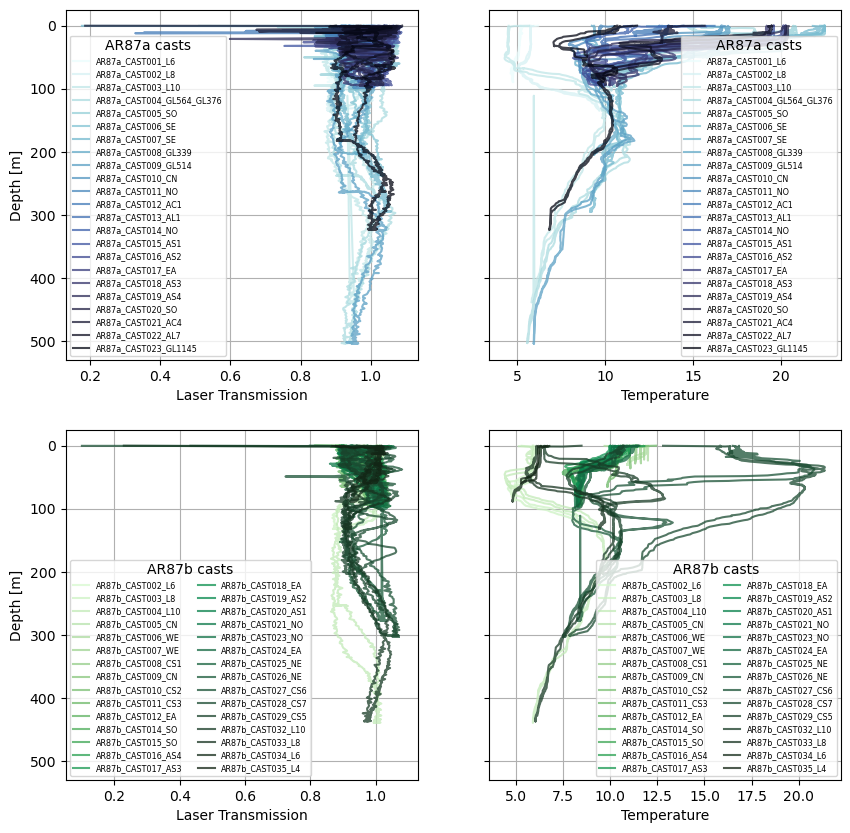

In [115]:
# Add cast data to one axes for each leg
fig, ax3 = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

# Top row is AR87a
# loop through list of AR87a files
n = 0
loop1 = pairs87a.copy()
while len(loop1)>0:
    color = rgb_a[n]
    key, value = loop1.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax3[0, 0] = addprofile2axes(ax3[0, 0], lisst_ds, "laser_transmission", color, legendtitle="AR87a casts")
    ax3[0, 1] = addprofile2axes(ax3[0, 1], lisst_ds, "temperature", color, legendtitle="AR87a casts")
    # Advance counter for colors
    n += 1

# Bottom row is AR87b
# loop through list of AR87b files
n = 0
loop2 = pairs87b.copy()
while len(loop2)>0:
    color = rgb_b[n]
    key, value = loop2.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax3[1, 0] = addprofile2axes(ax3[1, 0], lisst_ds, "laser_transmission", color, legendtitle="AR87b casts", legendcol=2)
    ax3[1, 1] = addprofile2axes(ax3[1, 1], lisst_ds, "temperature", color, legendtitle="AR87b casts", legendcol=2)
    # Advance counter for colors
    n += 1

# Add final figure elements
ax3[0, 0].invert_yaxis()
ax3[0, 0].grid()
ax3[0, 0].set_ylabel("Depth [m]")
ax3[0, 1].grid()

ax3[1, 0].grid()
ax3[1, 0].set_ylabel("Depth [m]")
ax3[1, 1].grid()

### Compare ambient light by depth

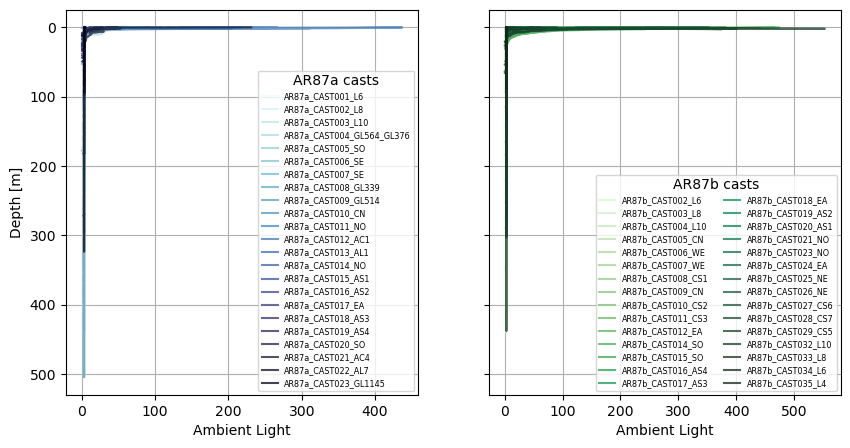

In [116]:
# Add cast data to one axes for each leg
fig, ax4 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
n = 0
loop1 = pairs87a.copy()
while len(loop1)>0:
    color = rgb_a[n]
    key, value = loop1.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax4[0] = addprofile2axes(ax4[0], lisst_ds, "ambient_light", color, legendtitle="AR87a casts")
    # Advance counter for colors
    n += 1

# loop through list of AR87b files
n = 0
loop2 = pairs87b.copy()
while len(loop2)>0:
    color = rgb_b[n]
    key, value = loop2.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax4[1] = addprofile2axes(ax4[1], lisst_ds, "ambient_light", color, legendtitle="AR87b casts", legendcol=2)
    # Advance counter for colors
    n += 1

# Add final figure elements
ax4[0].invert_yaxis()
ax4[0].grid()
ax4[0].set_ylabel("Depth [m]")
ax4[1].grid()

### Compare mean particle diameter by depth

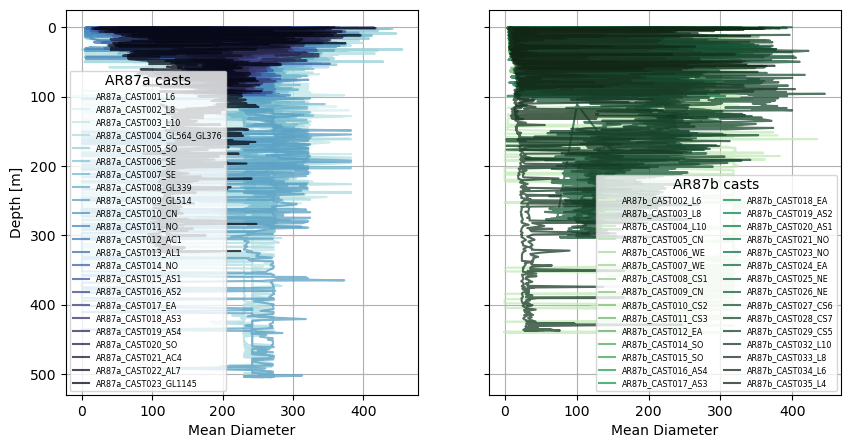

In [117]:
# Add cast data to one axes for each leg
fig, ax5 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
n = 0
loop1 = pairs87a.copy()
while len(loop1)>0:
    color = rgb_a[n]
    key, value = loop1.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax5[0] = addprofile2axes(ax5[0], lisst_ds, "mean_diameter", color, legendtitle="AR87a casts")
    # Advance counter for colors
    n += 1

# loop through list of AR87b files
n = 0
loop2 = pairs87b.copy()
while len(loop2)>0:
    color = rgb_b[n]
    key, value = loop2.pop(0)
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax5[1] = addprofile2axes(ax5[1], lisst_ds, "mean_diameter", color, legendtitle="AR87b casts", legendcol=2)
    # Advance counter for colors
    n += 1

# Add final figure elements
ax5[0].invert_yaxis()
ax5[0].grid()
ax5[0].set_ylabel("Depth [m]")
ax5[1].grid()

## Casts from LTER stations

In [11]:
# Split the list into legs A and B
pairs87a = [x for x in pairs if "87a" in x[0]]
pairs87b = [x for x in pairs if "87b" in x[0]]
# Filter the lists for LTER stations
lter_a = [x for x in pairs87a if "_L" in x[0]]
lter_b = [x for x in pairs87b if "_L" in x[0]]

In [12]:
# Get RGB values for each set of casts
rgb_a = rgb_from_dict(lter_a, cmo.ice_r)
rgb_b = rgb_from_dict(lter_b, cmo.algae)

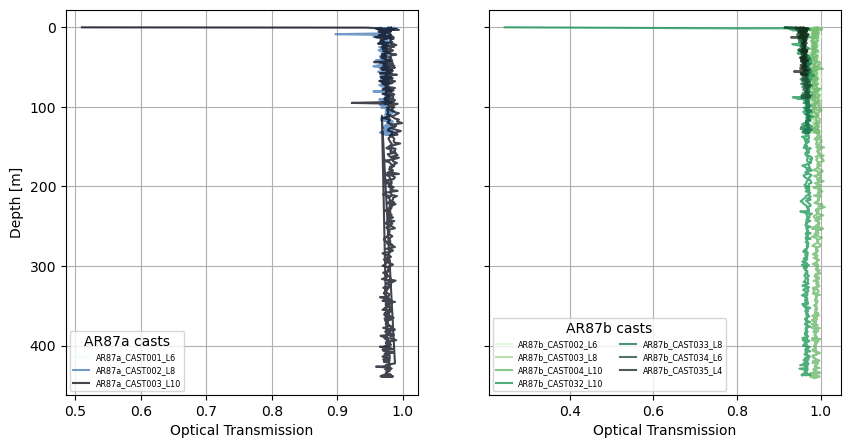

In [13]:
# Plot optical transmission for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
ax0[0] = plot_lisst_profiles(lter_a, rgb_a, ax0[0],
                             "optical_transmission", legendtitle="AR87a casts")

# loop through list of AR87b files
ax0[1] = plot_lisst_profiles(lter_b, rgb_b, ax0[1],
                             "optical_transmission", legendtitle="AR87b casts",
                             legendcol=2)

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()

## Casts from cross-shelf survey

In [14]:
# Split the list into legs A and B
pairs87a = [x for x in pairs if "87a" in x[0]]
pairs87b = [x for x in pairs if "87b" in x[0]]
# Filter the lists for cross-shelf survey stations
across_a = [x for x in pairs87a if ("_AC" in x[0])  or ("_CS" in x[0])]
across_b = [x for x in pairs87b if ("_AC" in x[0])  or ("_CS" in x[0])]


In [15]:
# Get RGB values for each set of casts
rgb_a = rgb_from_dict(across_a, cmo.ice_r)
rgb_b = rgb_from_dict(across_b, cmo.algae)

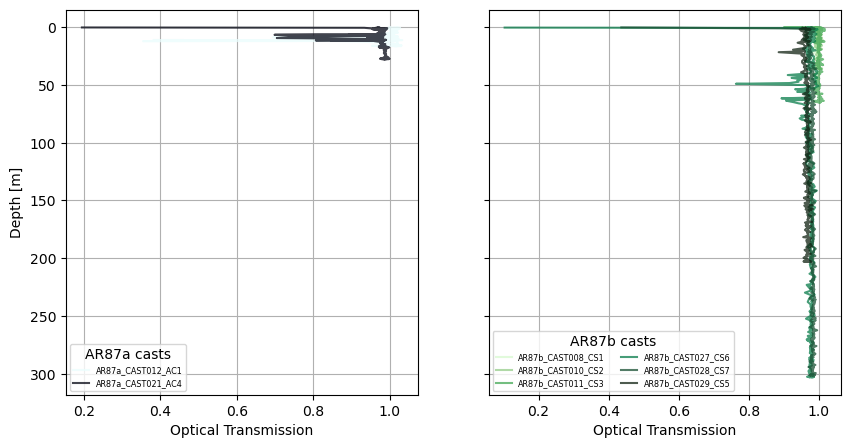

In [16]:
# Plot optical transmission for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
ax0[0] = plot_lisst_profiles(across_a, rgb_a, ax0[0],
                             "optical_transmission", legendtitle="AR87a casts")

# loop through list of AR87b files
ax0[1] = plot_lisst_profiles(across_b, rgb_b, ax0[1],
                             "optical_transmission", legendtitle="AR87b casts",
                             legendcol=2)

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()

## Casts from along-shelf survey

In [17]:
# Split the list into legs A and B
pairs87a = [x for x in pairs if "87a" in x[0]]
pairs87b = [x for x in pairs if "87b" in x[0]]
# Filter the lists for along-shelf survey stations
along_a = [x for x in pairs87a if ("_AL" in x[0]) or ("_AS" in x[0])]
along_b = [x for x in pairs87b if ("_AL" in x[0]) or ("_AS" in x[0])]

In [18]:
# Get RGB values for each set of casts
rgb_a = rgb_from_dict(along_a, cmo.ice_r)
rgb_b = rgb_from_dict(along_b, cmo.algae)

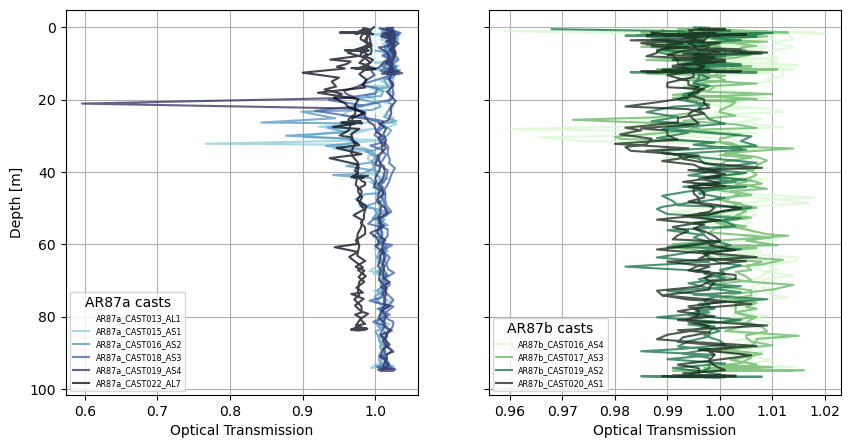

In [20]:
# Plot optical transmission for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
ax0[0] = plot_lisst_profiles(along_a, rgb_a, ax0[0],
                             "optical_transmission", legendtitle="AR87a casts")

# loop through list of AR87b files
ax0[1] = plot_lisst_profiles(along_b, rgb_b, ax0[1],
                             "optical_transmission", legendtitle="AR87b casts")

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()

## Casts from shallow-water moorings

In [21]:
# Split the list into legs A and B
pairs87a = [x for x in pairs if "87a" in x[0]]
pairs87b = [x for x in pairs if "87b" in x[0]]
# Filter the lists for shallow stations
shallow_a = [x for x in pairs87a if ("_CN" in x[0]) or ("_WE" in x[0])]
shallow_b = [x for x in pairs87b if ("_CN" in x[0]) or ("_WE" in x[0])]

In [22]:
# Get RGB values for each set of casts
rgb_a = rgb_from_dict(shallow_a, cmo.ice_r)
rgb_b = rgb_from_dict(shallow_b, cmo.algae)

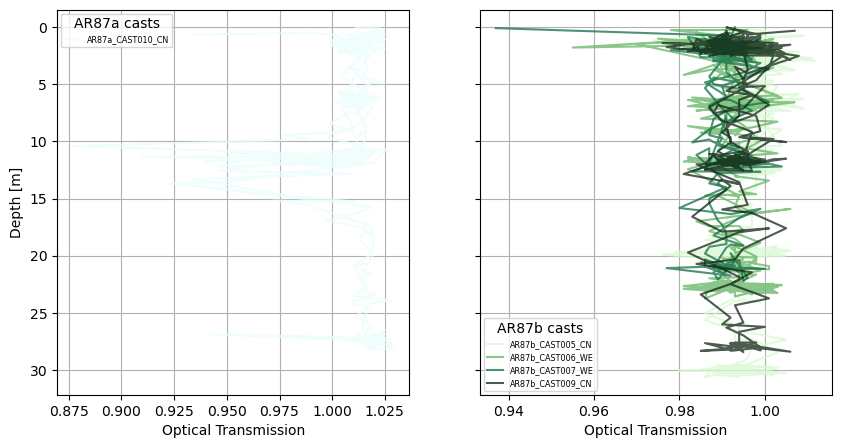

In [23]:
# Plot optical transmission for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
ax0[0] = plot_lisst_profiles(shallow_a, rgb_a, ax0[0],
                             "optical_transmission", legendtitle="AR87a casts")

# loop through list of AR87b files
ax0[1] = plot_lisst_profiles(shallow_b, rgb_b, ax0[1],
                             "optical_transmission", legendtitle="AR87b casts")

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()

## Casts from shelf-break moorings

In [24]:
# Split the list into legs A and B
pairs87a = [x for x in pairs if "87a" in x[0]]
pairs87b = [x for x in pairs if "87b" in x[0]]
# Filter the lists for shelf-break stations
shelf_a = [x for x in pairs87a if ("_NO" in x[0]) or ("_NE" in x[0]) or ("_EA" in x[0]) or ("_SE" in x[0]) or ("_SO" in x[0])]
shelf_b = [x for x in pairs87b if ("_NO" in x[0]) or ("_NE" in x[0]) or ("_EA" in x[0]) or ("_SE" in x[0]) or ("_SO" in x[0])]

In [25]:
# Get RGB values for each set of casts
rgb_a = rgb_from_dict(shelf_a, cmo.ice_r)
rgb_b = rgb_from_dict(shelf_b, cmo.algae)

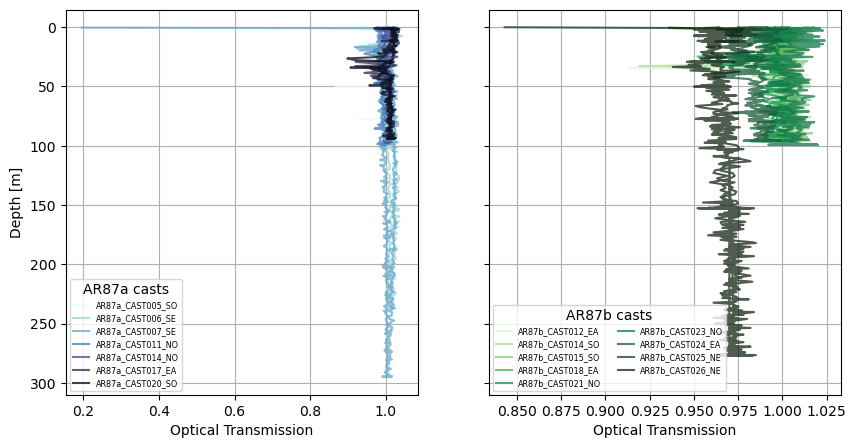

In [26]:
# Plot optical transmission for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
ax0[0] = plot_lisst_profiles(shelf_a, rgb_a, ax0[0],
                             "optical_transmission", legendtitle="AR87a casts")

# loop through list of AR87b files
ax0[1] = plot_lisst_profiles(shelf_b, rgb_b, ax0[1],
                             "optical_transmission", legendtitle="AR87b casts",
                             legendcol=2)

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()

## Casts from mobile asset stations

In [27]:
# Split the list into legs A and B
pairs87a = [x for x in pairs if "87a" in x[0]]
pairs87b = [x for x in pairs if "87b" in x[0]]
# Filter the lists for glider stations
glider_a = [x for x in pairs87a if "_GL" in x[0]]
glider_b = [x for x in pairs87b if "_GL" in x[0]]

In [29]:
# Get RGB values for each set of casts
rgb_a = rgb_from_dict(glider_a, cmo.ice_r)
# rgb_b = rgb_from_dict(glider_b, cmo.algae)

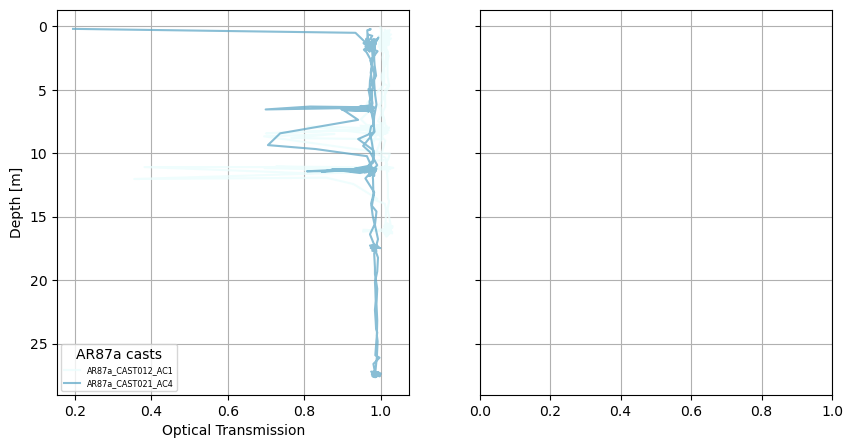

In [30]:
# Plot optical transmission for each leg
fig, ax0 = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# loop through list of AR87a files
ax0[0] = plot_lisst_profiles(across_a, rgb_a, ax0[0],
                             "optical_transmission", legendtitle="AR87a casts")

# # loop through list of AR87b files
# ax0[1] = plot_lisst_profiles(across_b, rgb_b, ax0[1],
#                              "optical_transmission", legendtitle="AR87b casts",
#                              legendcol=2)

# Add final figure elements
ax0[0].invert_yaxis()
ax0[0].grid()
ax0[0].set_ylabel("Depth [m]")
ax0[1].grid()